# Project 2 - Using Feed-Forward Neural Networks for linear regression and classification
## **Part a)** - Stochastic Gradient Descent
#### Program imports and program defaults

In [10]:
from networkClasses import *
from classSupport import *
from methodSupport import *

import autograd.numpy as anp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## Random seed
def_seed = 1
np.random.seed(def_seed); anp.random.seed(def_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10

#### Dataset setup

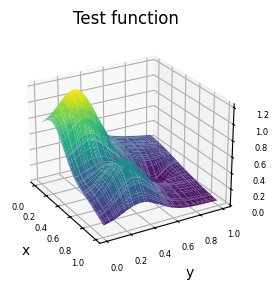

In [11]:
cases = ['1D','2D','Franke']
case_ = cases[2]
show = False

# Grid and data setup
a      = [1.0, 1.5, 1.2]                                   # Coefficients for exponential model
c0, c1 = 0.2, 0.95                                         # Noise scaling    
x0, xN = 0, 1                                              # Start and end of domain, x-axis
y0, yN = 0, 1                                              # Start and end of domain, y-axis
Nx, Ny = 100, 100                                          # Number of sample points

dataset = Initializer(problem_case=case_,sample_size=[Nx,Ny])
dataset.domain_setup(noise=c0)
dataset.test_function(a)
f = dataset.plot(labels=['Test function','x','y','dataset','true'])

### Gradient Descent Analysis
#### Plain GD and GD with momentum

Method: PlainGD
MSE, SGD:
0.008957970615528983
R²-score, SGD:
0.8958922653951166
MSE, Lin.Reg:
0.001883707618907288
R²-score, Lin.Reg:
0.9781079285388105 

Method: MomentumGD
MSE, SGD:
0.009900105141523195
R²-score, SGD:
0.8849429672332905
MSE, Lin.Reg:
0.001883707618907288
R²-score, Lin.Reg:
0.9781079285388105 



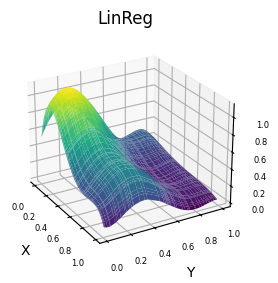

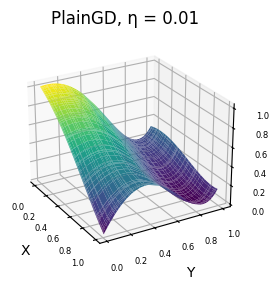

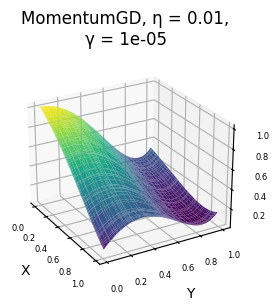

In [12]:
## Regression setup and initialization
eta = 0.01; n_iter = 10; lmbda = 0.0001

lin_gd = LinearRegressor(learning_rate=eta,num_iterations=n_iter)

## Design matrix
poly_deg = 5
if case_ == '1D':
    target = dataset.target[0]
    x = dataset.x
    X = lin_gd.design_matrix(x=x,poly_deg=poly_deg,intercept=True)
else:
    target = dataset.target_f#; target_f = dataset.target_f
    x = dataset.xf; y = dataset.yf
    X = lin_gd.design_matrix(x=[x,y],poly_deg=poly_deg,intercept=True)

X_tr,X_te,tar_tr,tar_te = train_test_split(X,target,test_size=0.2)

## Scaling
    # X_tr = lin_gd.scale(X_tr)
    # X_te = lin_gd.scale(X_te)
    # tar_tr = lin_gd.scale(tar_tr)

## Stochastic GD - parameters and method
batch_size = Nx // 2
batches = int(X_tr.shape[0]/batch_size)
epochs = 1000

if epochs > n_iter:
    n_iter = epochs

mom = [0., 0.00001]
GDMethod = [PlainGD(eta),MomentumGD(eta,momentum=mom[1])]

## Gradient method
GradMethod = LassoGrad(lmbda)
#GradMethod = AutoGrad(lmbda,mse_lasso)

## Linear prediction using method in the LinearRegressor class
lin_gd.linear_predict(X_tr,tar_tr,predict_type='Ridge',lmbda=lmbda)
prediction_reg = X @ lin_gd.beta_linreg
final_pred_reg = X_te @ lin_gd.beta_linreg
if case_ != '1D':
    pred_reg = prediction_reg.reshape(Nx,Ny)
    lin_gd.plot([dataset.xx,dataset.yy],pred_reg,labels=['LinReg','X','Y','data','SGD','LinReg'])

title_list= ['PlainGD, η = %g' %(eta),'MomentumGD, η = %g,\nγ = %g' %(eta,mom[1])]

for i,method in enumerate(GDMethod):

    lin_gd.reg_fit(X_tr,tar_tr,method,GradMethod,batches=batches,epoch=epochs)
    final_pred_test = X_te @ lin_gd.beta_gd
    prediction_gd = X @ lin_gd.beta_gd# + lin_gd.gd_intcept

    print(f'Method: {method.__class__.__name__}')
    if show == True:
        print('β_gd')
        print(lin_gd.beta_gd)
        print('β_lin')

    print('MSE, SGD:')
    print(lin_gd.predict(lin_gd.beta_gd,X_te,tar_te))
    print('R²-score, SGD:')
    print(lin_gd.score(final_pred_test,tar_te))
    print('MSE, Lin.Reg:')
    print(lin_gd.predict(lin_gd.beta_linreg,X_te,tar_te))
    print('R²-score, Lin.Reg:')
    print(lin_gd.score(final_pred_reg,tar_te),'\n')

    if case_ == '1D':
        lin_gd.plot(x,[target,prediction_gd,prediction_reg],labels=[title_list[i],'X','Y','data','SGD','LinReg'])
    else:
        pred_gd = prediction_gd.reshape(Nx,Ny)
        lin_gd.plot([dataset.xx,dataset.yy],pred_gd,labels=[title_list[i],'X','Y','data','SGD','LinReg'])

    lin_gd.reset()

plt.show()

#### Adagrad, RMSprop and ADAM

Method: Adagrad
MSE, SGD:
0.016322198250380397
R²-score, SGD:
0.8103066914873385
MSE, Lin.Reg:
0.001883707618907288
R²-score, Lin.Reg:
0.9781079285388105 

Method: RMSprop
MSE, SGD:
0.007489491185343637
R²-score, SGD:
0.9129586382770998
MSE, Lin.Reg:
0.001883707618907288
R²-score, Lin.Reg:
0.9781079285388105 

Method: ADAM
MSE, SGD:
0.005607850798565992
R²-score, SGD:
0.9348266847818392
MSE, Lin.Reg:
0.001883707618907288
R²-score, Lin.Reg:
0.9781079285388105 



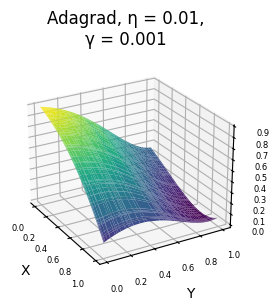

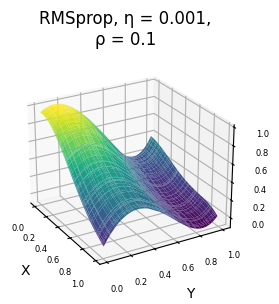

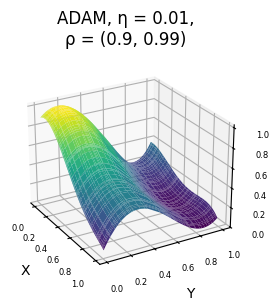

In [13]:
eta_ada, adagrad_mom = 0.01,0.001
eta_rms,rms_decay = 0.001,0.1
eta_ADAM, ADAM_decay = 0.01,[0.9, 0.99]

GDMethod = [Adagrad(eta_ada,momentum=adagrad_mom),RMSprop(eta,decay=rms_decay),ADAM(eta,decay_rates=ADAM_decay)]

title_list = ['Adagrad, η = %g,\nγ = %g'%(eta_ada,adagrad_mom),
              'RMSprop, η = %g,\nρ = %g' %(eta_rms,rms_decay),
              'ADAM, η = %g,\nρ = (%g, %g)' %(eta_ADAM,ADAM_decay[0],ADAM_decay[1])]

for i,method in enumerate(GDMethod):

    lin_gd.reg_fit(X_tr,tar_tr,method,GradMethod,batches=batches,epoch=epochs)

    prediction_gd = X @ lin_gd.beta_gd
    final_pred_test = X_te @ lin_gd.beta_gd

    print(f'Method: {method.__class__.__name__}')
    if show == True:
        print('β_gd')
        print(lin_gd.beta_gd)
        print('β_lin')
        print(lin_gd.beta_linreg)
    
    print('MSE, SGD:')
    print(lin_gd.predict(lin_gd.beta_gd,X_te,tar_te))
    print('R²-score, SGD:')
    print(lin_gd.score(final_pred_test,tar_te))
    print('MSE, Lin.Reg:')
    print(lin_gd.predict(lin_gd.beta_linreg,X_te,tar_te))
    print('R²-score, Lin.Reg:')
    print(lin_gd.score(final_pred_reg,tar_te),'\n')

    if case_ == '1D':
        lin_gd.plot(x,[target,prediction_gd,prediction_reg],labels=[title_list[i],'X','Y','data','SGD','LinReg'])
    else:
        pred_gd = prediction_gd.reshape(Nx,Ny)
        lin_gd.plot([dataset.xx,dataset.yy],pred_gd,labels=[title_list[i],'X','Y','data','SGD','LinReg'])

    lin_gd.reset()

plt.show()

#### Study of parameters $\lambda$ and $\eta$

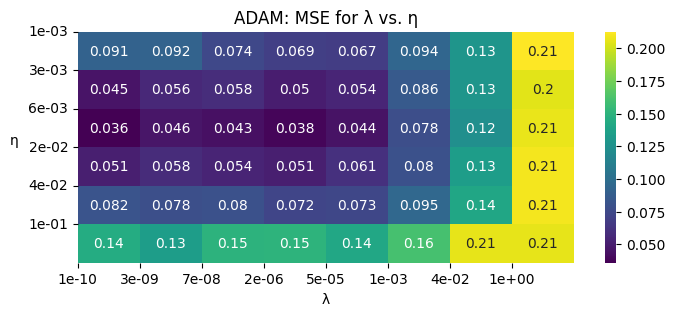

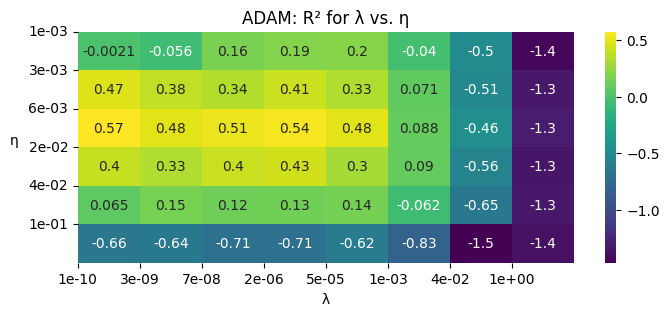

In [14]:
## Regression setup and initialization
num_param = 6
eta = anp.logspace(-3,-1,num_param)
lmbda = anp.logspace(-10,0,num_param+2)
n_iter = 10

decay_rms = 0.1
adagrad_mom = 0.001
ADAM_decay = [0.9, 0.99]

mom = [0., 0.001]
#GDMethod = [PlainGD(eta),MomentumGD(eta,momentum=mom[1])]

## Stochastic GD - parameters
batch_size = Nx // 2
batches = int(Nx/batch_size)
epochs = 1000

poly_deg = 3
lin_pred_type = 'Ridge'

if epochs > n_iter:
    n_iter = epochs

MSE_GD = anp.zeros((len(eta),len(lmbda)))
R2_GD = anp.zeros_like(MSE_GD)
for i in range(len(eta)):
    for j in range(len(lmbda)):
            
        lin_gd = LinearRegressor(learning_rate=eta[i],num_iterations=n_iter)

        #GDMethod = PlainGD(eta[i],lmbda=lmbda[j],lp=2)
        #GDMethod = MomentumGD(eta[i],momentum=mom[1],lmbda=lmbda[j],lp=2) 
        #GDMethod = Adagrad(eta[i],momentum=adagrad_mom,lmbda=lmbda[j],lp=2)
        #GDMethod = RMSprop(eta[i],decay=decay_rms,lmbda=lmbda[j])
        GDMethod = ADAM(eta[i],ADAM_decay)#,lmbda=lmbda[j])  
        
        GradMethod = RidgeGrad(lmbda[j])

        ## Design matrix
        if case_ == '1D':
            target = dataset.target[0]
            x = dataset.x
            X = lin_gd.design_matrix(x=x,poly_deg=poly_deg,intercept=False)
        else:
            target = dataset.target_f
            x = dataset.xf; y = dataset.yf
            X = lin_gd.design_matrix(x=[x,y],poly_deg=poly_deg,intercept=False)

        ## Training/test dataset split
        X_tr,X_te,tar_tr,tar_te = train_test_split(X,target,test_size=0.2)

        ## Scaling
        # X_tr = lin_gd.scale(X_tr)
        # X_te = lin_gd.scale(X_te)
        # tar_tr = lin_gd.scale(tar_tr)

        ## GD-fitting and linear prediction
        lin_gd.linear_predict(X_tr,tar_tr,predict_type=lin_pred_type,lmbda=lmbda[j])
        prediction_reg = X @ lin_gd.beta_linreg + lin_gd.intcept

    
        lin_gd.reg_fit(X_tr,tar_tr,GDMethod,GradMethod,batches=batches,epoch=epochs)

        prediction_gd = X_te @ lin_gd.beta_gd

        MSE_GD[i,j] = lin_gd.predict(lin_gd.beta_gd,X_te,tar_te)
        R2_GD[i,j] = r2_score(tar_te,prediction_gd)

        #print('(i,j): ',i,j)
        #print('l:',lmbda[j])
        #print('e',eta[i])
        #print('MSE: ',lin_gd.predict(lin_gd.beta_gd,X,target))
        
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Regularization, λ:',lmbda[j])
            print('Learning rate,  η:',eta[i])
            print('MSE              :',lin_gd.predict(lin_gd.beta_gd,X_te,tar_te))
            print('R²-score         :',r2_score(tar_te,prediction_gd))

        lin_gd.reset()

fig0,ax = lambda_eta(MSE_GD,[lmbda,eta],
                axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_GD.min(),MSE_GD.max()]
                )


_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η')

fig1,bx = lambda_eta(R2_GD,[lmbda,eta],
                axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                cbar_lim=[R2_GD.min(),R2_GD.max()]
                )

_ = bx.set_title(f'{GDMethod.__class__.__name__}: R² for λ vs. η')


#### Mini-batching and Epoch - study
This part shows results from one SGD-method varying the size of the batchs and number of epochs, together with learning rate

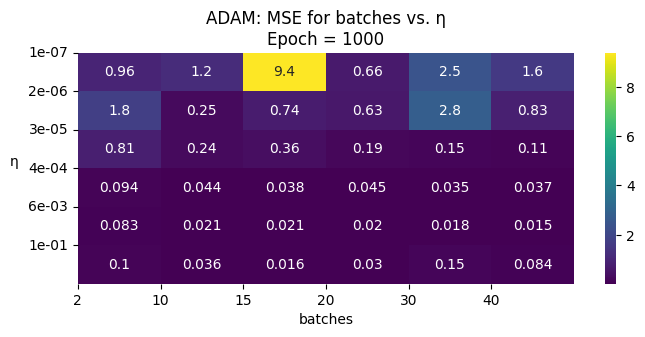

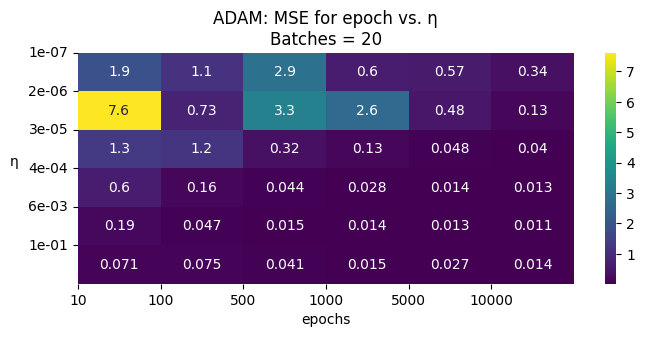

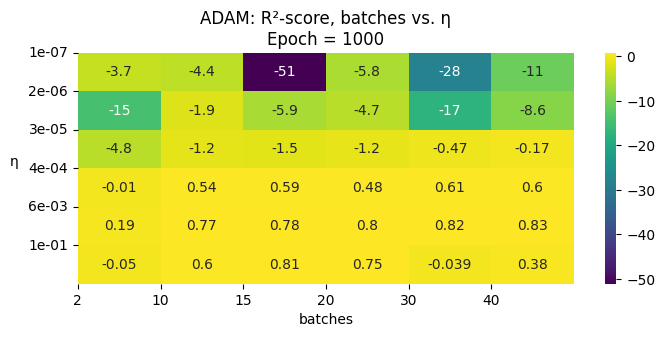

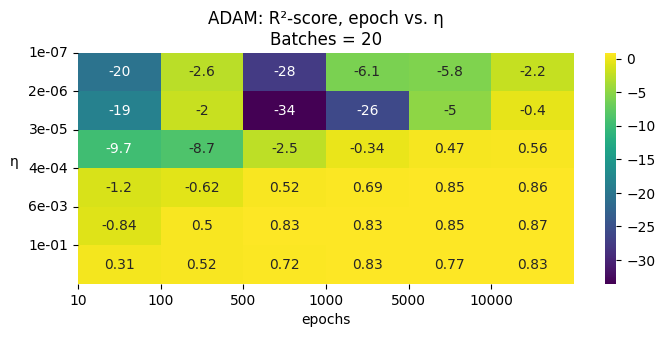

In [15]:
## Regression setup and initialization
num_param = 6
eta = anp.logspace(-7,-1,num_param)
lmbda = 1e-5 #anp.logspace(-10,0,num_param+2)

decay_rms = 0.9
adagrad_mom = 0.001
ADAM_decay = [0.9, 0.99]

mom = [0., 0.001]

## Stochastic GD - parameters
batches = [2,10,15,20,30,40]
epochs  = [10,100,500,1000,5000,10000]
batch = batches[3]; epoch = epochs[-3]

poly_deg = 6
lin_pred_type = 'Ridge'

MSE_BATCH = anp.zeros((len(eta),len(batches)))
MSE_EPOCH = anp.zeros((len(eta),len(epochs)))
R2_BATCH = anp.zeros_like(MSE_BATCH)
R2_EPOCH = anp.zeros_like(MSE_EPOCH)

for i in range(len(eta)):
    for j in range(len(batches)):
            
        lin_gd = LinearRegressor(learning_rate=eta[i])

        GDMethod =  RMSprop(eta[i],decay=decay_rms)#RMSprop(eta[i],decay=decay_rms) ADAM(eta[i],ADAM_decay) Adagrad(eta[i],momentum=adagrad_mom) #MomentumGD(eta[i],momentum=mom[1]) PlainGD(eta[i])
        GradMethod = RidgeGrad(lmbda)

        ## Design matrix
        if case_ == '1D':
            target = dataset.target[0]
            x = dataset.x
            X = lin_gd.design_matrix(x=x,poly_deg=poly_deg,intercept=False)
        else:
            target = dataset.target_f#; target_f = dataset.target_f
            x = dataset.xf; y = dataset.yf
            X = lin_gd.design_matrix(x=[x,y],poly_deg=poly_deg,intercept=False)

        ## Training/test dataset split
        X_tr,X_te,tar_tr,tar_te = train_test_split(X,target,test_size=0.2)

        ## Scaling
        # X_tr = lin_gd.scale(X_tr)
        # X_te = lin_gd.scale(X_te)
        # tar_tr = lin_gd.scale(tar_tr)

        ## GD-fitting and linear prediction
        lin_gd.linear_predict(X_tr,tar_tr,predict_type=lin_pred_type,lmbda=lmbda)
        prediction_reg = X @ lin_gd.beta_linreg + lin_gd.intcept

    
        lin_gd.reg_fit(X_tr,tar_tr,GDMethod,GradMethod,batches=batches[j],epoch=epoch)

        prediction_gd = X_te @ lin_gd.beta_gd + lin_gd.gd_intcept

        MSE_BATCH[i,j] = lin_gd.predict(lin_gd.beta_gd,X_te,tar_te)
        R2_BATCH[i,j] = r2_score(tar_te,prediction_gd)
                
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Batches: ',batches[j])
            print('Learning rate, η:',eta[i])
            print('MSE: ',lin_gd.predict(lin_gd.beta_gd,X,target))
            print('R²-score:',r2_score(tar_te,prediction_gd))

        lin_gd.reset()

for i in range(len(eta)):
    for j in range(len(epochs)):
            
        lin_gd = LinearRegressor(learning_rate=eta[i])

        GDMethod   = ADAM(eta[i],ADAM_decay) #RMSprop(eta[i],decay=decay_rms) ADAM(eta[i],ADAM_decay) Adagrad(eta[i],momentum=adagrad_mom) #MomentumGD(eta[i],momentum=mom[1]) PlainGD(eta[i])
        GradMethod = RidgeGrad(lmbda)

        ## Design matrix
        if case_ == '1D':
            target = dataset.target[0]
            x = dataset.x
            X = lin_gd.design_matrix(x=x,poly_deg=poly_deg,intercept=False)
        else:
            target = dataset.target_f#; target_f = dataset.target_f
            x = dataset.xf; y = dataset.yf
            X = lin_gd.design_matrix(x=[x,y],poly_deg=poly_deg,intercept=False)

        ## Training/test dataset split
        X_tr,X_te,tar_tr,tar_te = train_test_split(X,target,test_size=0.2)

        ## Scaling
        # X_tr = lin_gd.scale(X_tr)
        # X_te = lin_gd.scale(X_te)
        # tar_tr = lin_gd.scale(tar_tr)

        ## GD-fitting and linear prediction
        lin_gd.linear_predict(X_tr,tar_tr,predict_type=lin_pred_type,lmbda=lmbda)
        prediction_reg = X @ lin_gd.beta_linreg + lin_gd.intcept

    
        lin_gd.reg_fit(X_tr,tar_tr,GDMethod,GradMethod,batches=batch,epoch=epochs[j])

        prediction_gd = X_te @ lin_gd.beta_gd + lin_gd.gd_intcept

        MSE_EPOCH[i,j] = lin_gd.predict(lin_gd.beta_gd,X_te,tar_te)
        R2_EPOCH[i,j] = r2_score(tar_te,prediction_gd)
                
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Epochs: ',batches[j])
            print('Learning rate, η:',eta[i])
            print('MSE: ',lin_gd.predict(lin_gd.beta_gd,X_te,tar_te))
            print('R²-score:',r2_score(tar_te,prediction_gd))

        lin_gd.reset()

fig0,ax = lambda_eta(MSE_BATCH,[batches,eta],
                axis_tick_labels=[[f'{y:.0f}' for y in batches],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_BATCH.min(),MSE_BATCH.max()]
                )
fig1,bx = lambda_eta(MSE_EPOCH,[epochs,eta],
                axis_tick_labels=[[f'{y:.0f}' for y in epochs],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_EPOCH.min(),MSE_EPOCH.max()]
                )

ax.set_title(f'{GDMethod.__class__.__name__}: MSE for batches vs. η\nEpoch = %i' %(epoch))
bx.set_title(f'{GDMethod.__class__.__name__}: MSE for epoch vs. η\nBatches = %i' %(batch))
ax.set_xlabel('batches'); _ = bx.set_xlabel('epochs')

fig2,cx = lambda_eta(R2_BATCH,[batches,eta],
                axis_tick_labels=[[f'{y:.0f}' for y in batches],[f'{y:.0e}' for y in eta]],
                cbar_lim=[R2_BATCH.min(),R2_BATCH.max()]
                )
fig3,dx = lambda_eta(R2_EPOCH,[epochs,eta],
                axis_tick_labels=[[f'{y:.0f}' for y in epochs],[f'{y:.0e}' for y in eta]],
                cbar_lim=[R2_EPOCH.min(),R2_EPOCH.max()]
                )

cx.set_title(f'{GDMethod.__class__.__name__}: R²-score, batches vs. η\nEpoch = %i' %(epoch))
dx.set_title(f'{GDMethod.__class__.__name__}: R²-score, epoch vs. η\nBatches = %i' %(batch))
cx.set_xlabel('batches'); _ = dx.set_xlabel('epochs')


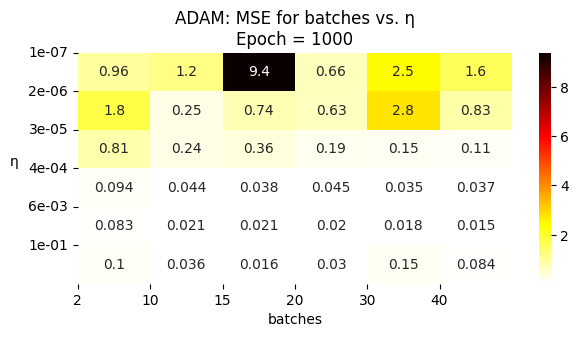

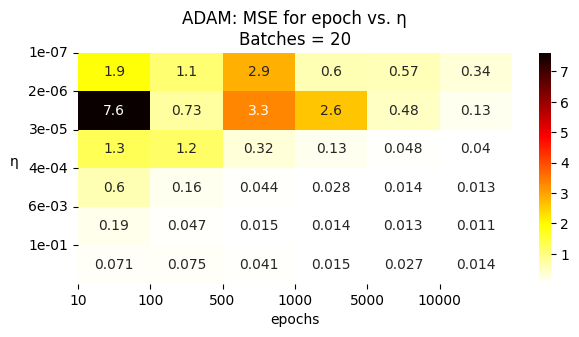

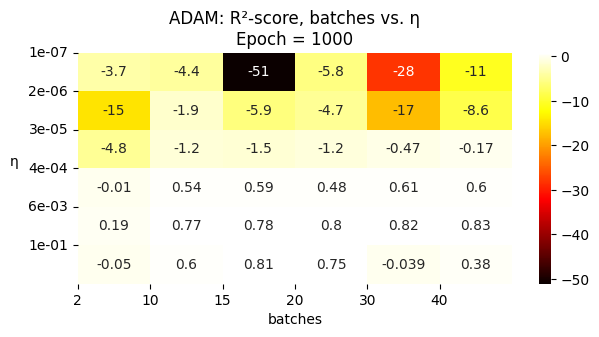

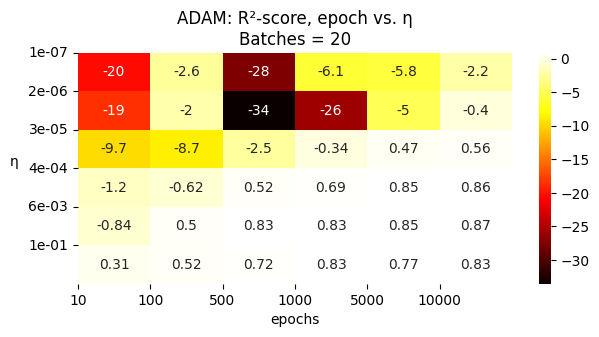

In [16]:
fig0,ax = lambda_eta(MSE_BATCH,[batches,eta],
                axis_tick_labels=[[f'{y:.0f}' for y in batches],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_BATCH.min(),MSE_BATCH.max()],
                cmap='hot_r'
                )
fig1,bx = lambda_eta(MSE_EPOCH,[epochs,eta],
                axis_tick_labels=[[f'{y:.0f}' for y in epochs],[f'{y:.0e}' for y in eta]],
                cbar_lim=[MSE_EPOCH.min(),MSE_EPOCH.max()],
                cmap='hot_r'
                )
fig0.set_size_inches(7,3); fig1.set_size_inches(7,3)
ax.set_title(f'{GDMethod.__class__.__name__}: MSE for batches vs. η\nEpoch = %i' %(epoch))
bx.set_title(f'{GDMethod.__class__.__name__}: MSE for epoch vs. η\nBatches = %i' %(batch))
ax.set_xlabel('batches'); _ = bx.set_xlabel('epochs')

fig2,cx = lambda_eta(R2_BATCH,[batches,eta],
                axis_tick_labels=[[f'{y:.0f}' for y in batches],[f'{y:.0e}' for y in eta]],
                cbar_lim=[R2_BATCH.min(),R2_BATCH.max()],
                cmap='hot'
                )
fig3,dx = lambda_eta(R2_EPOCH,[epochs,eta],
                axis_tick_labels=[[f'{y:.0f}' for y in epochs],[f'{y:.0e}' for y in eta]],
                cbar_lim=[R2_EPOCH.min(),R2_EPOCH.max()],
                cmap='hot'
                )
fig2.set_size_inches(7,3); fig3.set_size_inches(7,3)
cx.set_title(f'{GDMethod.__class__.__name__}: R²-score, batches vs. η\nEpoch = %i' %(epoch))
dx.set_title(f'{GDMethod.__class__.__name__}: R²-score, epoch vs. η\nBatches = %i' %(batch))
cx.set_xlabel('batches'); _ = dx.set_xlabel('epochs')

#### Scikit-learn's `SGDRegressor`
An attempt to create a prediction model using Scikit-learn's implementation. Current setup does not produce good enough results for comparison.

In [17]:
from sklearn.linear_model import SGDRegressor

regressor = SGDRegressor(penalty='l2',random_state=def_seed,
                         eta0=0.0001,
                         learning_rate='adaptive', 
                         max_iter=2000,tol=1e-3
                         )

regressor.fit(X_tr,tar_tr)
final_pred = regressor.predict(X_te)

print('Training iterations:',regressor.n_iter_)
print('Accuracy, test:',regressor.score(X_te,tar_te))
print('Accuracy, training:',regressor.score(X_tr,tar_tr))
print(mse_predict(final_pred,tar_te))

Training iterations: 29
Accuracy, test: 0.5732142776844575
Accuracy, training: 0.5816649672544238
247.52466999359473


/home/anders_tb/02-uio/fysstk4155/project-2-fys-stk4155/p2-venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
